# Chuẩn bị

## Conect Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Face Recognition

In [3]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 74kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=1b684dcfaf2a9e0b6eabc75ca3e04c0c70f3570eded69e7dd36814bc03e89fea
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


## Install MTCNN

In [4]:
!pip install MTCNN

     |████████████████████████████████| 2.3MB 12.3MB/s 


In [5]:
from mtcnn import MTCNN

def face_locations_MTCNN(image):
  r = []
  for x in MTCNN().detect_faces(image):
    bounding_box = x['box']

    left = bounding_box[0] 
    top = bounding_box[1]
    right = (bounding_box[0]+bounding_box[2]) 
    bottom = (bounding_box[1] + bounding_box[3])

    r.append((top, right, bottom, left))
  return r

## Read webcam

In [6]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = video.videoWidth;
      captureCanvas.height = video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px"; //videoRect.width
        imgElement.style.height = videoRect.height + "px"; //videoRect.height
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result,
              'videoWidth': video.videoWidth, //video.videoWidth
              'videoHeight': video.videoHeight //video.videoHeight
              };
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data


## Convert Image

In [7]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)


    return image_array, jpeg_bytes


In [8]:
def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0
    output: 
          drawing_b64: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes


## Find_face


In [9]:
from mtcnn import MTCNN
import tensorflow as tf
import cv2
import face_recognition 

def find_face(frame, frameWidth, frameHeight, count): 

    drawing_array = np.zeros([frameHeight,frameWidth,4], dtype=np.uint8)

    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample=0, model="cnn")
    face_encodings = face_recognition.face_encodings(frame, face_locations)

    for (top, right, bottom, left) in face_locations:
      drawing_array = cv2.rectangle(drawing_array, (left, top), (right, bottom), (255, 0, 0) , 2)

      drawing_array = cv2.putText(drawing_array, '{}'.format(count), (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 1.0, (255, 0, 0), 1)


    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    return drawing_array, len(face_locations), face_encodings

## Check_face


In [10]:
def check_face(frame, frameWidth, frameHeight): 

    drawing_array = np.zeros([frameHeight,frameWidth,4], dtype=np.uint8)
    name = 'Unknown'
    accuracy = 0

    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample=0, model="cnn")
    face_encodings = face_recognition.face_encodings(frame, face_locations)

    predictions = predict(face_encodings, face_locations, model_path="trained_knn_model.clf",distance_threshold=0.3)

    for (top, right, bottom, left), prediction in zip(face_locations, predictions):

      name = prediction[0]   
      accuracy = int((1 - prediction[2])*100) 

      drawing_array = cv2.rectangle(drawing_array, (left, top), (right, bottom), (255, 0, 0) , 2)

      if name != 'Unknown':
        drawing_array = cv2.rectangle(drawing_array, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        drawing_array = cv2.putText(drawing_array, '{}({}%)'.format(name,accuracy) if name != 'Unknown' else name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    return drawing_array, name, accuracy

## Get data train

In [11]:
def get_data_train(train_dir, verbose=False):
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_locations_MTCNN(frame)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                print(img_path,class_dir)
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    return X, y


## KNN

In [12]:

import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}


def train(X, y, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


def predict(faces_encodings, face_locations, knn_clf=None, model_path=None, distance_threshold=0.6):
    if len(face_locations) == 0:
        return []

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc, dist) if rec else ("Unknown", loc, dist) for pred, loc, rec, dist  in zip(knn_clf.predict(faces_encodings), face_locations, are_matches,closest_distances[0])]

## Data check in

In [18]:
# authenticate
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())
# create, and save df
from gspread_dataframe import set_with_dataframe
import pandas as pd

title = 'Ghi Nhan Check In'

worksheet = gc.open(title).sheet1

### Tạo file sheet

In [17]:
# # tạo file sheet
# df = pd.DataFrame({'STT':[], 'Tên':[], 'Thời gian':[], 'Hình':[], 'Chính xác':[]})
# gc.create(title) 
# set_with_dataframe(gc.open(title).sheet1, df) 

### Set Check In

In [19]:
from gspread_dataframe import get_as_dataframe
from datetime import datetime
import pytz

def setCheckIn(name, image_byte, accuracy):

  time = datetime.now(pytz.timezone('Asia/Saigon'))
  path_image = '/content/drive/My Drive/Image_Checking/{}_{}.jpg'.format(name,time.strftime("%H_%M_%S_%d_%m_%Y"))
  save_image(path_image,image_byte)

  rowNext = len(worksheet.get_all_values()) + 1
  cell_list = worksheet.range('A{}:E{}'.format(rowNext,rowNext))
  cell_list[0].value = rowNext - 1
  cell_list[1].value = name
  cell_list[2].value = time.strftime("%H:%M:%S %d/%m/%Y")
  cell_list[3].value = path_image
  cell_list[4].value = accuracy
  worksheet.update_cells(cell_list)

## Save image

In [16]:
def save_image(path, image_byte):
    with open(path, 'wb') as f:
      f.write(image_byte)


# Run

## Create data train

In [20]:
known_face = [] 
known_face_encodings = []
known_face_names = []

<IPython.core.display.Javascript object>

Nghi


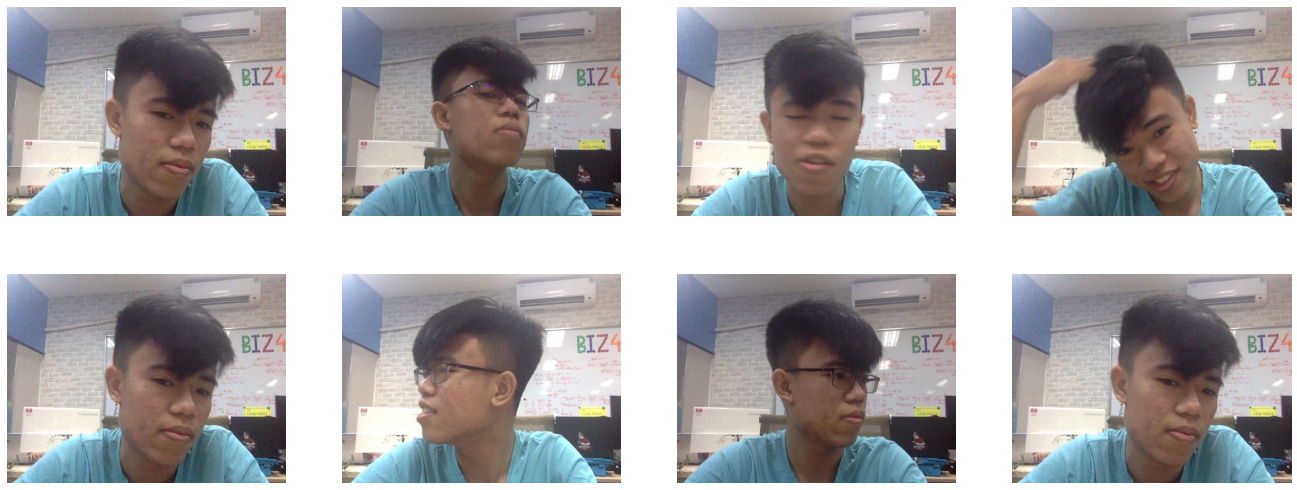

In [22]:
import matplotlib.pylab as plt

data_face = [] 
data_face_encodings = []
data_face_names = []
name = 'Nghi'
path_name = 'image_train/'

start_input() 
label_html = 'Capturing...'
img_data = ''
max_count = 30
min_face_distances = 0.3

while True:
  
    js_reply = take_photo(label_html, img_data)  
    if not js_reply:
      known_face.extend(data_face)
      known_face_encodings.extend(data_face_encodings)
      known_face_names.extend(data_face_names)

      print(name)
      cols = 4
      rows = 2
      fig, axs = plt.subplots(rows,cols,figsize=(6 * cols - 1, 5 * rows - 1))
      for i in range(rows):
        for j in range(cols):
          target = np.random.choice(len(data_face))
          axs[i][j].grid('off')
          axs[i][j].axis('off')
          axs[i][j].imshow(np.squeeze(data_face[target]))

      plt.show()

      break

    frame, image_byte = js_reply_to_image(js_reply) 

    drawing_array, faces_found_number, face_encodings = find_face(
        frame, 
        js_reply['videoWidth'], 
        js_reply['videoHeight'], 
        '{}%-{}'.format(int(len(data_face) / max_count * 100), len(data_face)))
        
    if len(face_encodings) == 1:
      
      face_distances = [0]
      if len(data_face_encodings) > 0:
        face_distances = face_recognition.face_distance(data_face_encodings, face_encodings[0]) 

      if (min(face_distances) > min_face_distances or len(data_face_encodings) == 0) and len(data_face_encodings) < max_count:
        data_face_names.append(name)
        data_face_encodings.append(face_encodings[0])
        data_face.append(frame)
        save_image('{}{}_{}.jpg'.format(path_name,name,len(data_face_encodings)),image_byte)

    img_data = drawing_array_to_bytes(drawing_array) 



### Show data



In [ ]:
import matplotlib.pylab as plt

def showFace(index):
  plt.imshow(known_face[index])
  plt.show()
  print(known_face_names[index])
  # print(known_face_encodings[index])

In [ ]:
# len(known_face_names)

In [ ]:
# showFace(0)

## Train KNN

In [23]:
print("Training KNN classifier...")
classifier = train(known_face_encodings, known_face_names, model_save_path="trained_knn_model.clf", n_neighbors=2)
print("Training complete!")


Training KNN classifier...
Training complete!


## Run Check Face

In [24]:
recorded = np.array(worksheet.get_all_values())[:,1][1:].tolist()

start_input()  
label_html = 'Capturing...'
img_data = ''
count = 0 

while True:
  
    # lấy hình tư webcame 
    js_reply = take_photo(label_html, img_data)           
    if not js_reply:
        break

    # chuyển hình từ base64 to np.array
    frame, image_byte = js_reply_to_image(js_reply)

    drawing_array, nameUser, accuracy = check_face(frame, js_reply['videoWidth'], js_reply['videoHeight'])    

    if nameUser != 'Unknown' and nameUser not in recorded:
      recorded.append(nameUser)
      setCheckIn(nameUser,image_byte, accuracy)

    img_data = drawing_array_to_bytes(drawing_array) 


<IPython.core.display.Javascript object>